In [1]:
import pandas as pd

# Function to load data for specified months
def load_data(months):
    base_url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_"
    data_frames = []

    for month in months:
        url = f"{base_url}{month}.parquet"
        df = pd.read_parquet(url)
        data_frames.append(df)
    
    data = pd.concat(data_frames)
    return data

# Function to clean the data
def clean_data(data):
    # Drop rows with null values in critical columns
    data = data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance'])
    
    # Convert pickup and dropoff times to datetime
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'], errors='coerce')
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'], errors='coerce')
    
    # Drop rows with invalid datetime conversions
    data = data.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    
    # Filter out data outside the last six months
    data = data[(data['tpep_pickup_datetime'] >= '2023-09-01') & (data['tpep_pickup_datetime'] <= '2024-02-29')]
    
    # Calculate trip duration in minutes
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60
    
    # Filter out invalid trip durations and distances
    data = data[(data['trip_duration'] > 0) & (data['trip_duration'] < 1440)]  # Trips less than 24 hours
    data = data[(data['trip_distance'] > 0) & (data['trip_distance'] < 100)]
    
    return data

# Load and clean the data for the specified months
months = ['2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02']
data = load_data(months)
cleaned_data = clean_data(data)
cleaned_data.to_parquet('cleaned_data.parquet')
print("Data ingestion and cleaning completed, and saved to 'cleaned_data.parquet'")


Data ingestion and cleaning completed, and saved to 'cleaned_data.parquet'


Data Summary:
           VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count  1.840466e+07                    18404662                    18404662   
mean   1.760659e+00  2023-11-30 02:51:13.917402  2023-11-30 03:08:53.379088   
min    1.000000e+00         2023-09-01 00:00:00         2023-09-01 00:01:51   
25%    2.000000e+00         2023-10-18 11:54:31         2023-10-18 12:15:16   
50%    2.000000e+00  2023-11-29 15:13:21.500000  2023-11-29 15:38:10.500000   
75%    2.000000e+00  2024-01-13 16:06:08.750000         2024-01-13 16:21:47   
max    6.000000e+00         2024-02-29 00:00:00         2024-02-29 22:23:26   
std    4.292904e-01                         NaN                         NaN   

       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.776790e+07   1.840466e+07  1.776790e+07  1.840466e+07   
mean      1.359761e+00   3.410368e+00  1.783255e+00  1.656396e+02   
min       0.000000e+00   1.000000e-02  1.000000e+00  1.000000e+00  

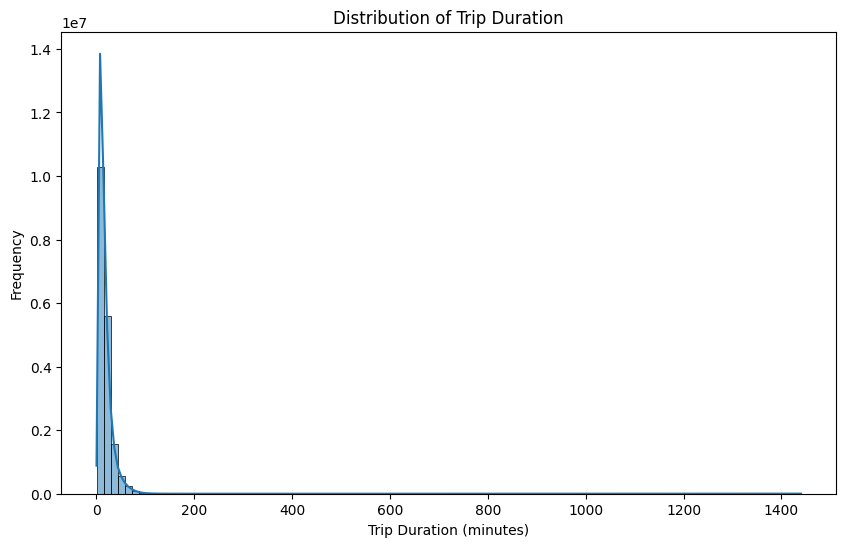

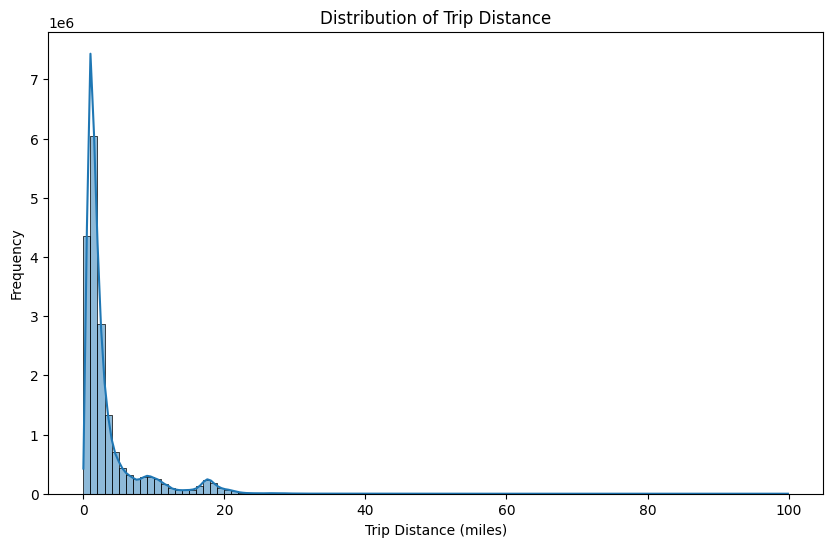

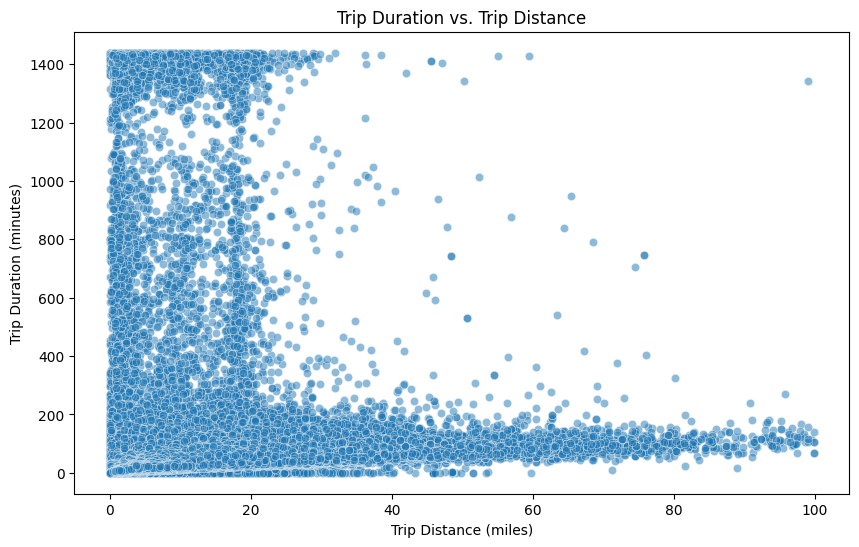

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
data = pd.read_parquet('cleaned_data.parquet')

# Data summary and null value check
print("Data Summary:")
print(data.describe())
    
print("\nNull Values:")
print(data.isnull().sum())

# Plot distribution of trip duration
plt.figure(figsize=(10, 6))
sns.histplot(data['trip_duration'], bins=100, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of trip distance
plt.figure(figsize=(10, 6))
sns.histplot(data['trip_distance'], bins=100, kde=True)
plt.title('Distribution of Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.show()

# Plot trip duration vs. trip distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='trip_duration', data=data, alpha=0.5)
plt.title('Trip Duration vs. Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Trip Duration (minutes)')
plt.show()


Monthly Average Trip Length:
tpep_pickup_datetime
2023-09    18.912585
2023-10    18.430947
2023-11    18.285736
2023-12    18.290704
2024-01    15.712969
2024-02    16.039222
Freq: M, Name: trip_duration, dtype: float64


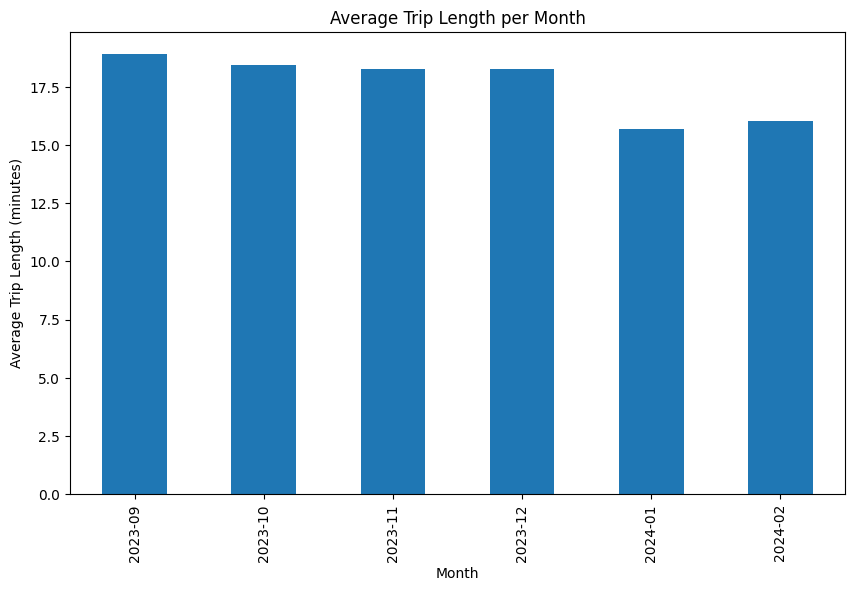

45-Day Rolling Average Trip Length:
tpep_pickup_datetime
2023-09-01 00:00:00    19.433333
2023-09-01 00:00:02    16.733333
2023-09-01 00:00:07    13.366667
2023-09-01 00:00:09    10.970833
2023-09-01 00:00:14    10.983333
                         ...    
2024-02-28 23:59:53    15.936307
2024-02-28 23:59:53    15.936306
2024-02-28 23:59:54    15.936308
2024-02-29 00:00:00    15.936551
2024-02-29 00:00:00    15.936802
Name: trip_duration, Length: 18404662, dtype: float64


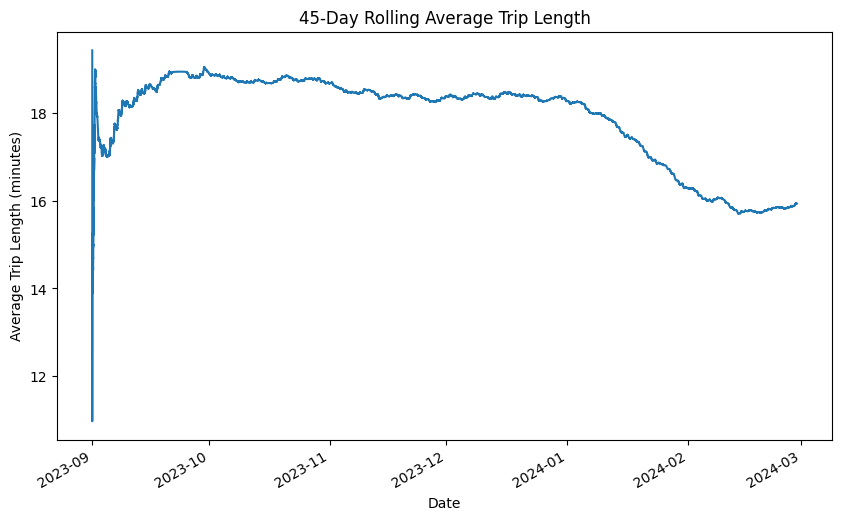

In [3]:
# Function to calculate monthly average trip length
def calculate_monthly_average(data):
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60
    
    # Filter data to include only the last six months
    data = data[(data['tpep_pickup_datetime'] >= '2023-09-01') & (data['tpep_pickup_datetime'] <= '2024-02-29')]
    
    # Group by month and calculate the mean trip duration
    monthly_avg = data.groupby(data['tpep_pickup_datetime'].dt.to_period('M'))['trip_duration'].mean()
    return monthly_avg

# Function to calculate 45-day rolling average trip length
def calculate_rolling_average(data):
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

    # Sort by pickup datetime
    data = data.sort_values(by='tpep_pickup_datetime')

    data.set_index('tpep_pickup_datetime', inplace=True)
    rolling_avg = data['trip_duration'].rolling(window='45D').mean()
    data.reset_index(inplace=True)
    
    return rolling_avg

# Function to visualize monthly average trip length
def visualize_monthly_average(monthly_avg):
    monthly_avg.plot(kind='bar', figsize=(10, 6), title="Average Trip Length per Month")
    plt.xlabel("Month")
    plt.ylabel("Average Trip Length (minutes)")
    plt.show()

# Function to visualize 45-day rolling average trip length
def visualize_rolling_average(rolling_avg):
    rolling_avg.plot(figsize=(10, 6), title="45-Day Rolling Average Trip Length")
    plt.xlabel("Date")
    plt.ylabel("Average Trip Length (minutes)")
    plt.show()

# Load cleaned data
data = pd.read_parquet('cleaned_data.parquet')

# Calculate and visualize monthly average
monthly_avg = calculate_monthly_average(data)
print("Monthly Average Trip Length:")
print(monthly_avg)
visualize_monthly_average(monthly_avg)

# Calculate and visualize 45-day rolling average
rolling_avg = calculate_rolling_average(data)
print("45-Day Rolling Average Trip Length:")
print(rolling_avg)
visualize_rolling_average(rolling_avg)
